In [1]:
import numpy as np
import os
import networkx as nx
from scipy.ndimage import zoom
def load_and_validate_data(file_path):
    """
    Load data from a file and return it.
    Return None if data is missing.
    """
    try:
        loaded_data = np.load(file_path)
        
        ppg_f = loaded_data.get('ppg_f')
        ecg_f = loaded_data.get('ecg_f')
        seg_dbp = loaded_data.get('seg_dbp')
        seg_sbp = loaded_data.get('seg_sbp')
        
        
        if ppg_f is None or ecg_f is None or seg_dbp is None or seg_sbp is None:
            return None

        return ppg_f, ecg_f, seg_dbp, seg_sbp
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def combine_data_from_folder(folder_path, batch_size=100):
    """
    Combine data from all valid files in the folder in batches.
    """
    combined_ppg = []
    combined_ecg = []
    combined_seg_dbp = []
    combined_seg_sbp = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        
        if not file_path.endswith('.npz'):
            continue
        
        data = load_and_validate_data(file_path)
        
        if data is None:
            print(f"Skipping invalid file: {file_path}")
            continue
        
        ppg_f, ecg_f, seg_dbp, seg_sbp = data
        
        combined_ppg.append(ppg_f)
        combined_ecg.append(ecg_f)
        combined_seg_dbp.append(seg_dbp)
        combined_seg_sbp.append(seg_sbp)
        
        if len(combined_ppg) >= batch_size:
            combined_ppg = np.concatenate(combined_ppg, axis=0)
            combined_ecg = np.concatenate(combined_ecg, axis=0)
            combined_seg_dbp = np.concatenate(combined_seg_dbp, axis=0)
            combined_seg_sbp = np.concatenate(combined_seg_sbp, axis=0)
            
            yield combined_ppg, combined_ecg, combined_seg_dbp, combined_seg_sbp
            
            combined_ppg = []
            combined_ecg = []
            combined_seg_dbp = []
            combined_seg_sbp = []
            

    if combined_ppg:
        combined_ppg = np.concatenate(combined_ppg, axis=0)
    else:
        combined_ppg = np.array([])
        
    if combined_ecg:
        combined_ecg = np.concatenate(combined_ecg, axis=0)
    else:
        combined_ecg = np.array([])
        
    if combined_seg_dbp:
        combined_seg_dbp = np.concatenate(combined_seg_dbp, axis=0)
    else:
        combined_seg_dbp = np.array([])
        
    if combined_seg_sbp:
        combined_seg_sbp = np.concatenate(combined_seg_sbp, axis=0)
    else:
        combined_seg_sbp = np.array([])

    yield combined_ppg, combined_ecg, combined_seg_dbp, combined_seg_sbp
train_dir = 'C:\\Users\\nihal\\Desktop\\NIHAL_IMP_DOCS\\Internship_PPG\\Train_data'
val_dir = 'C:\\Users\\nihal\\Desktop\\NIHAL_IMP_DOCS\\Internship_PPG\\Validation_data'
test_dir = 'C:\\Users\\nihal\\Desktop\\NIHAL_IMP_DOCS\\Internship_PPG\\Test_data'

In [2]:
def create_visibility_graph(ppg_signal):
    n = len(ppg_signal)
    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i + 1, n):
            visible = True
            for k in range(i + 1, j):
                if ppg_signal[k] >= ppg_signal[i] + (ppg_signal[j] - ppg_signal[i]) * (k - i) / (j - i):
                    visible = False
                    break
            if visible:
                G.add_edge(i, j)
                
    return G

def graph_to_adjacency_matrix_image(G, size):
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix_resized = zoom(adj_matrix, (size / adj_matrix.shape[0], size / adj_matrix.shape[1]), order=0)
    return adj_matrix_resized

def graph_to_flattened_adjacency_matrix(G, size):
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix_resized = zoom(adj_matrix, (size / adj_matrix.shape[0], size / adj_matrix.shape[1]), order=0)
    flattened_adj = adj_matrix_resized.flatten()
    return flattened_adj[:size * size]  

def generate_vg_image(ppg_signal, size):
    G = create_visibility_graph(ppg_signal)
    vg_image = graph_to_adjacency_matrix_image(G, size)
    return vg_image

def process_signal(i, ppg_signal, vg_image_size):
    """
    Generate a VG image for a given PPG signal.
    """
    #print(f"VG img {i + 1}")
    ppg_signal = ppg_signal.flatten()
    vg_image = generate_vg_image(ppg_signal, vg_image_size)
    return vg_image.flatten()

vg_image_size=224

In [3]:
import numpy as np
from scipy.signal import find_peaks

def select_n_peak_window(ppg_signal, n_peaks=3):
    ppg_3peak=[]
    for ppg in ppg_signal:
        x=ppg.flatten()
        peaks, _ = find_peaks(x, distance=50)  
    
    
    
        if len(peaks) < n_peaks:
            raise ValueError(f"Not enough peaks detected. Detected peaks: {len(peaks)}")
    
    
        start_index = peaks[0]
        end_index = peaks[n_peaks - 1]  
    
    
        ppg_window = x[start_index:end_index + 1]
        ppg_3peak.append(np.array(ppg_window))
    
    return ppg_3peak

def reshape_ppg_3_peaks(ppg_signal):
    ppg_3_peak_reshaped = []

    for ppg_window in ppg_signal:
        reshaped_window = ppg_window.reshape(1, -1)  
        ppg_3_peak_reshaped.append(np.array(reshaped_window))
        
    return ppg_3_peak_reshaped

In [4]:
val_data_generator = combine_data_from_folder(val_dir, batch_size=10)

In [ ]:
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor


output_dir = 'Val_VG'
os.makedirs(output_dir, exist_ok=True)


for batch_idx, (combined_ppg_batch, combined_ecg_batch, combined_seg_dbp_batch, combined_seg_sbp_batch) in enumerate(val_data_generator):
    
    output_file = os.path.join(output_dir, f'Val_VG_batch_{batch_idx + 1}.npz')
    if os.path.exists(output_file):
        print(f"Batch {batch_idx + 1} already processed. Skipping...")
        continue
        
    print(f"Processing Batch {batch_idx + 1}...")
    print(len(combined_seg_dbp_batch))
    ppg_peaks_3=select_n_peak_window(combined_ppg_batch)
    ppg_peaks_3_reshaped=reshape_ppg_3_peaks(ppg_peaks_3)
    with ThreadPoolExecutor() as executor:
        
        vg_images = list(executor.map(process_signal, range(len(ppg_peaks_3_reshaped)), ppg_peaks_3_reshaped, [vg_image_size]*len(ppg_peaks_3_reshaped)))
        
    
    np.savez_compressed(output_file, vg_images=vg_images)
    print(f"Batch {batch_idx + 1} processing complete.")


Processing Batch 1...
4971
VG img 1
VG img 2
VG img 3
VG img 4
VG img 5
VG img 6
VG img 7
VG img 8
VG img 9
VG img 10
VG img 11
VG img 12
VG img 13
VG img 14
VG img 15
VG img 16
VG img 17
VG img 18
VG img 19
VG img 20
VG img 21
VG img 22
VG img 23
VG img 24
VG img 25
VG img 26
VG img 27
VG img 28
VG img 29
VG img 30
VG img 31
VG img 32
VG img 33
VG img 34
VG img 35
VG img 36
VG img 37
VG img 38
VG img 39VG img 40
VG img 41
VG img 42
VG img 43

VG img 44
VG img 45
VG img 46
VG img 47
VG img 48
VG img 49
VG img 50
VG img 51
VG img 52
VG img 53
VG img 54
VG img 55
VG img 56
VG img 57
VG img 58
VG img 59
VG img 60
VG img 61
VG img 62
VG img 63
VG img 64
VG img 65
VG img 66
VG img 67
VG img 68
VG img 69
VG img 70
VG img 71
VG img 72
VG img 73VG img 74

VG img 75
VG img 76
VG img 77
VG img 78
VG img 79
VG img 80
VG img 81
VG img 82
VG img 83
VG img 84
VG img 85
VG img 86
VG img 87
VG img 88
VG img 89
VG img 90
VG img 91
VG img 92
VG img 93
VG img 94
VG img 95
VG img 96VG img 97

VG img 98
VG

In [5]:
import numpy as np
from skimage.transform import resize

def normalize_series(X):
    """Normalize the time series data to range [-1, 1]."""
    X_min = np.min(X)
    X_max = np.max(X)
    X_norm = (X - X_min) / (X_max - X_min)
    X_norm = 2 * X_norm - 1  # Normalize to [-1, 1]
    return X_norm

def gasf(X,target_shape=(224, 224)):
    """Compute the Gramian Angular Summation Field (GASF) image."""
    # Step 1: Normalize the time series
    X_norm = normalize_series(X)
    
    # Step 2: Convert to polar coordinates (arccos)
    phi = np.arccos(X_norm)
    
    # Step 3: Construct the GASF matrix
    GASF_matrix = np.cos(phi[:, None] + phi[None, :])
    gasf_matrix_resized = resize(GASF_matrix, target_shape, anti_aliasing=True)
    #print(gasf_matrix_resized.shape)
    return gasf_matrix_resized

In [ ]:
import numpy as np


gasf_all = []
all_sbp_values = []
all_dbp_values = []

for batch_idx, (combined_ppg_batch, combined_ecg_batch, combined_seg_dbp_batch, combined_seg_sbp_batch) in enumerate(val_data_generator):
   
    if batch_idx + 1>9 :
        break
    print(f"Processing Batch {batch_idx + 1}...")
    print(len(combined_seg_dbp_batch))
    ppg_peaks_3=select_n_peak_window(combined_ppg_batch)
    ppg_peaks_3_reshaped=reshape_ppg_3_peaks(ppg_peaks_3)
    for ppg in ppg_peaks_3_reshaped:
        gasf_matrix=gasf(ppg.flatten())
        gasf_all.append(np.array(gasf_matrix))
    
    all_sbp_values.append(np.array(combined_seg_sbp_batch.flatten()))
    all_dbp_values.append(np.array(combined_seg_dbp_batch.flatten()))

    print(f"Batch {batch_idx + 1} processing complete.")

#gasf_all = np.concatenate(gasf_all, axis=0)
all_sbp_values = np.concatenate(all_sbp_values, axis=0)
all_dbp_values = np.concatenate(all_dbp_values, axis=0)     

Processing Batch 1...
4971
Batch 1 processing complete.
Processing Batch 2...
5731
Batch 2 processing complete.
Processing Batch 3...
4148


In [ ]:
y = np.column_stack((all_sbp_values, all_dbp_values))

In [8]:
gasf_image=gasf_all[0]

In [9]:
gasf_image

array([[0.99781426, 0.9771148 , 0.94216576, ..., 0.77321898, 0.79711409,
        0.80346548],
       [0.9771148 , 0.92486531, 0.86801253, ..., 0.64741153, 0.67629666,
        0.68404727],
       [0.94216576, 0.86801253, 0.79637171, ..., 0.54265752, 0.5745874 ,
        0.58319889],
       ...,
       [0.77321898, 0.64741153, 0.54265752, ..., 0.22240918, 0.25975512,
        0.26993188],
       [0.79711409, 0.67629666, 0.5745874 , ..., 0.25975512, 0.29673227,
        0.30679852],
       [0.80346548, 0.68404727, 0.58319889, ..., 0.26993188, 0.30679852,
        0.31683189]])

In [10]:
gasf_image.shape

(224, 224)

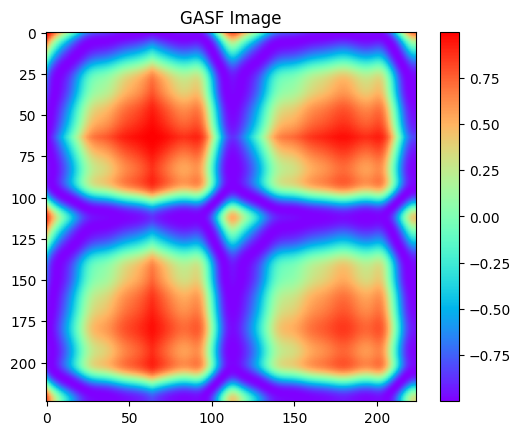

In [11]:

import matplotlib.pyplot as plt

plt.imshow(gasf_image, cmap='rainbow')
plt.title("GASF Image")
plt.colorbar()
plt.show()

In [12]:
import numpy as np
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import Ridge



In [13]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

# Define the batch size
batch_size = 32

# Function to generate image batches
def image_generator(images, labels, batch_size):
    num_samples = images.shape[0]
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            batch_images_reshaped = batch_images.reshape(-1, 224, 224, 1)
            batch_images_rgb = np.concatenate([batch_images_reshaped] * 3, axis=-1)
            batch_images_preprocessed = preprocess_input(batch_images_rgb)
            yield batch_images_preprocessed, batch_labels


In [14]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = Flatten(name='flatten')(x)
#x = Dense(4096, activation='relu', name='fc1')(x)
#x = Dense(4096, activation='relu', name='fc2')(x)
output = Dense(512, activation='linear',name='fc1')(x)  


model = Model(inputs=base_model.input, outputs=output)


model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
image_list = gasf_all
labels = y
num_samples = len(image_list)

In [ ]:
# Define a new model to extract features from the 'fc1' layer of the trained model
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('fc1').output)

# Function to extract features
def extract_features(generator, num_samples, batch_size):
    features = []
    num_batches = num_samples // batch_size + (num_samples % batch_size != 0)
    
    for i in range(num_batches):
        batch_images, _ = next(generator)
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
    
    return np.vstack(features)


feature_generator_normal = image_generator(image_list, np.zeros((num_samples,)), batch_size)


features_normal = extract_features(feature_generator_normal, num_samples)


features_normal_flattened= features_normal.reshape(features_normal.shape[0],-1)


features= features_normal_flattened

In [ ]:
from sklearn.model_selection import train_test_split

vg_features_train,vg_features_test,label_vgg_train,label_vgg_test=train_test_split(features,labels, test_size=0.2, random_state=42)
ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(vg_features_train, label_vgg_train)


predicted_values_split = ridge_model.predict(vg_features_test)

In [ ]:
predicted_sbp =predicted_values_split[:, 0]  # Assuming the first column is SBP
predicted_dbp =predicted_values_split[:, 1]  # Assuming the second column is DBP

true_sbp = label_vgg_test[:, 0]  # True SBP values from q
true_dbp = label_vgg_test[:, 1]  # True DBP values from q

def calculate_metrics(predicted, true):
    # Calculate R (correlation coefficient)
    R = np.corrcoef(predicted, true)[0, 1]

    # Calculate MAE (Mean Absolute Error)
    MAE = np.mean(np.abs(predicted - true))

    # Calculate RMSE (Root Mean Squared Error)
    RMSE = np.sqrt(np.mean((predicted - true) ** 2))

    normalization_factor = np.mean(true)
    NMAE = MAE / normalization_factor
    # Calculate ME ± SD (Mean Error ± Standard Deviation)
    ME = np.mean(predicted - true)
    SD = np.std(predicted - true)

    return R, MAE, RMSE, (ME, SD),NMAE

# Calculate metrics for SBP
sbp_metrics = calculate_metrics(predicted_sbp, true_sbp)
print(f"SBP Metrics: R={sbp_metrics[0]}, MAE={sbp_metrics[1]}, RMSE={sbp_metrics[2]}, ME±SD={sbp_metrics[3]}, NMAE={sbp_metrics[4]}")

# Calculate metrics for DBP
dbp_metrics = calculate_metrics(predicted_dbp, true_dbp)
print(f"DBP Metrics: R={dbp_metrics[0]}, MAE={dbp_metrics[1]}, RMSE={dbp_metrics[2]}, ME±SD={dbp_metrics[3]}, NMAE={dbp_metrics[4]}")

# FULL PEAKS

In [6]:
import numpy as np


gasf_all_fullpeaks = []
all_sbp_values_fullpeaks = []
all_dbp_values_fullpeaks = []

for batch_idx, (combined_ppg_batch, combined_ecg_batch, combined_seg_dbp_batch, combined_seg_sbp_batch) in enumerate(val_data_generator):
   
        
    print(f"Processing Batch {batch_idx + 1}...")
    print(len(combined_seg_dbp_batch))
    #ppg_peaks_3=select_n_peak_window(combined_ppg_batch)
    #ppg_peaks_3_reshaped=reshape_ppg_3_peaks(ppg_peaks_3)
    for ppg in combined_ppg_batch:
        gasf_matrix=gasf(ppg.flatten())
        gasf_all_fullpeaks.append(np.array(gasf_matrix))
    
    all_sbp_values_fullpeaks.append(np.array(combined_seg_sbp_batch.flatten()))
    all_dbp_values_fullpeaks.append(np.array(combined_seg_dbp_batch.flatten()))

    print(f"Batch {batch_idx + 1} processing complete.")
    break

#gasf_all = np.concatenate(gasf_all, axis=0)
all_sbp_values_fullpeaks = np.concatenate(all_sbp_values_fullpeaks, axis=0)
all_dbp_values_fullpeaks = np.concatenate(all_dbp_values_fullpeaks, axis=0)     

Processing Batch 1...
4971
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224,

In [8]:
y1 = np.column_stack((all_sbp_values_fullpeaks,all_dbp_values_fullpeaks))

In [9]:
gasf_image1=gasf_all_fullpeaks[0]

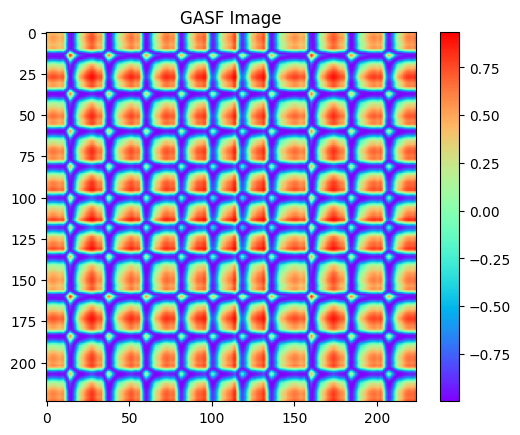

In [10]:

import matplotlib.pyplot as plt

plt.imshow(gasf_image1, cmap='rainbow')
plt.title("GASF Image")
plt.colorbar()
plt.show()

In [11]:
import numpy as np
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import Ridge


gasf_images_normal_1 = np.array(gasf_all_fullpeaks)

In [12]:
import numpy as np
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

# Define the batch size
batch_size = 32

# Function to generate image batches
def image_generator(images, labels, batch_size):
    num_samples = images.shape[0]
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            batch_images_reshaped = batch_images.reshape(-1, 224, 224, 1)
            batch_images_rgb = np.concatenate([batch_images_reshaped] * 3, axis=-1)
            batch_images_preprocessed = preprocess_input(batch_images_rgb)
            yield batch_images_preprocessed, batch_labels

In [13]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense


base_model_1 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model_1.layers:
    layer.trainable = False


x = base_model_1.output
x = Flatten(name='flatten')(x)
#x = Dense(4096, activation='relu', name='fc1')(x)
#x = Dense(4096, activation='relu', name='fc2')(x)
output = Dense(512, activation='linear',name='fc1')(x)  


model_1 = Model(inputs=base_model_1.input, outputs=output)


model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
images = gasf_images_normal_1
labels = y1
num_samples = images.shape[0]

In [15]:
# Define a new model to extract features from the 'fc1' layer of the trained model
feature_extractor_1 = Model(inputs=model_1.input, outputs=model_1.get_layer('fc1').output)

# Function to extract features
def extract_features(generator, num_samples):
    features = []
    for batch_images, _ in generator:
        batch_features = feature_extractor_1.predict(batch_images)
        features.append(batch_features)
        if len(features) * batch_size >= num_samples:
            break
    return np.vstack(features)

feature_generator_normal_1 = image_generator(images, np.zeros((num_samples,)), batch_size)


features_normal_1 = extract_features(feature_generator_normal_1, num_samples)


features_normal_flattened_1= features_normal_1.reshape(features_normal_1.shape[0],-1)


features_1= features_normal_flattened_1

1/1 [==============================] - 2s 2s/step


In [16]:
from sklearn.model_selection import train_test_split

vg_features_train,vg_features_test,label_vgg_train,label_vgg_test=train_test_split(features_1,labels, test_size=0.2, random_state=42)
ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(vg_features_train, label_vgg_train)


predicted_values_split = ridge_model.predict(vg_features_test)

In [17]:
predicted_sbp =predicted_values_split[:, 0]  # Assuming the first column is SBP
predicted_dbp =predicted_values_split[:, 1]  # Assuming the second column is DBP

true_sbp = label_vgg_test[:, 0]  # True SBP values from q
true_dbp = label_vgg_test[:, 1]  # True DBP values from q

def calculate_metrics(predicted, true):
    # Calculate R (correlation coefficient)
    R = np.corrcoef(predicted, true)[0, 1]

    # Calculate MAE (Mean Absolute Error)
    MAE = np.mean(np.abs(predicted - true))

    # Calculate RMSE (Root Mean Squared Error)
    RMSE = np.sqrt(np.mean((predicted - true) ** 2))

    # Calculate ME ± SD (Mean Error ± Standard Deviation)
    ME = np.mean(predicted - true)
    SD = np.std(predicted - true)

    return R, MAE, RMSE, (ME, SD)

# Calculate metrics for SBP
sbp_metrics = calculate_metrics(predicted_sbp, true_sbp)
print(f"SBP Metrics: R={sbp_metrics[0]}, MAE={sbp_metrics[1]}, RMSE={sbp_metrics[2]}, ME±SD={sbp_metrics[3]}")

# Calculate metrics for DBP
dbp_metrics = calculate_metrics(predicted_dbp, true_dbp)
print(f"DBP Metrics: R={dbp_metrics[0]}, MAE={dbp_metrics[1]}, RMSE={dbp_metrics[2]}, ME±SD={dbp_metrics[3]}")

SBP Metrics: R=0.7270084808987004, MAE=9.753032354429227, RMSE=12.557289840944868, ME±SD=(0.1642557259486658, 12.556215520848243)
DBP Metrics: R=0.6695297443668223, MAE=4.861859925674978, RMSE=6.441706285446091, ME±SD=(-0.08331879807730139, 6.44116742880067)


In [4]:
test_data_generator = combine_data_from_folder(test_dir, batch_size=10)

In [5]:
for batch_idx, (combined_ppg_batch, combined_ecg_batch, combined_seg_dbp_batch, combined_seg_sbp_batch) in enumerate(test_data_generator):
    print(batch_idx+1)
    print(len(combined_seg_dbp_batch))

1
5184
2
4828
3
4731
4
4640
5
2823
6
7198
7
4812
8
5214
9
4203
10
4815
11
5614
12
3847
13
3984
14
2980
15
6517
16
4499
17
5090
18
3425
19
6159
20
7488
21
4454
22
4642
23
5970
24
7211
25
4608
26
6880
27
5224
28
6739
29
5127
30
3722
31
3014
32
4628
33
3756
34
7772
35
6172
36
3863
37
3645
38
4822
39
4098
40
6161
41
5186
42
8704
43
4225
44
5612
45
7722
46
6336


KeyboardInterrupt: 